In [10]:

import random

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision.transforms import Compose, ToTensor, CenterCrop, Pad, Normalize
from torchvision.datasets import OxfordIIITPet

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
TORCH_GEN = torch.manual_seed(RANDOM_SEED)

In [19]:
PATCH_SIZE = 16
IMAGE_SIZE = PATCH_SIZE * 16  # both height and width are the same
INPUT_SIZE = 3 * PATCH_SIZE ** 2  # 3 channels for RGB

mean = [0.485, 0.456, 0.406]  # ImageNet normalization
std = [0.229, 0.224, 0.225]

transforms = Compose([
    Pad(IMAGE_SIZE // 2),
    CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),
    ToTensor(),
    Normalize(mean, std)
])

In [16]:

ds = OxfordIIITPet(root='data', download=True, split='trainval', transform=transforms)

train_ds, val_ds = random_split(ds, [0.8, 0.2])

First lets write a basic function to visualize a grid of images with optional parameters to display the images with denotations whether they were correctly classified or not.

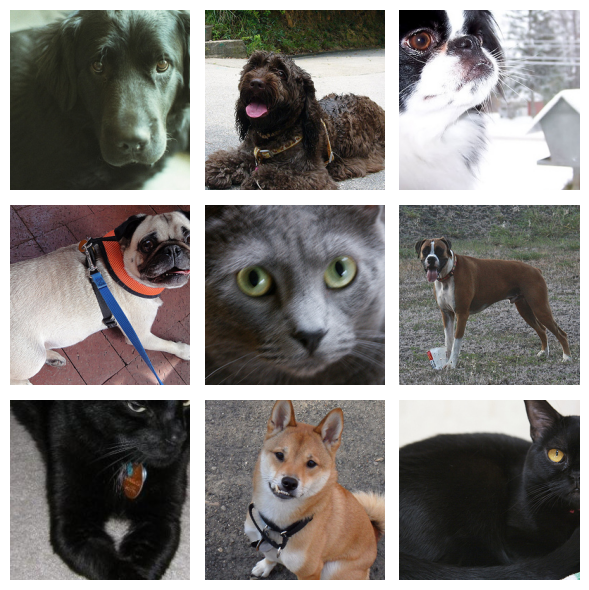

In [23]:
import math

def plot_imgs(imgs, pred_labels=None, true_labels=None, figsize=(12, 12)):
    num_imgs = len(imgs)
    nrows = int(math.ceil(math.sqrt(num_imgs)))
    ncols = int(math.ceil(num_imgs / nrows))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if num_imgs > 1 else [axes]

    for i, (img, ax) in enumerate(zip(imgs, axes)):
        img = img.clone()
        img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)


        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')

        if pred_labels is not None and true_labels is not None:
            symbol = '✓' if pred_labels[i] == true_labels[i] else '✗'
            color = 'limegreen' if pred_labels[i] == true_labels[i] else 'red'
            ax.text(0.3, 0.3, symbol, color=color, fontsize=40,
                    ha='right', va='top', transform=ax.transAxes,
                    fontweight='bold')

    plt.tight_layout()
    plt.show()


imgs, labels = map(list, zip(*[ds[i] for i in random.sample(range(len(ds)), 9)]))
fake_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
plot_imgs(imgs, figsize=(6, 6))

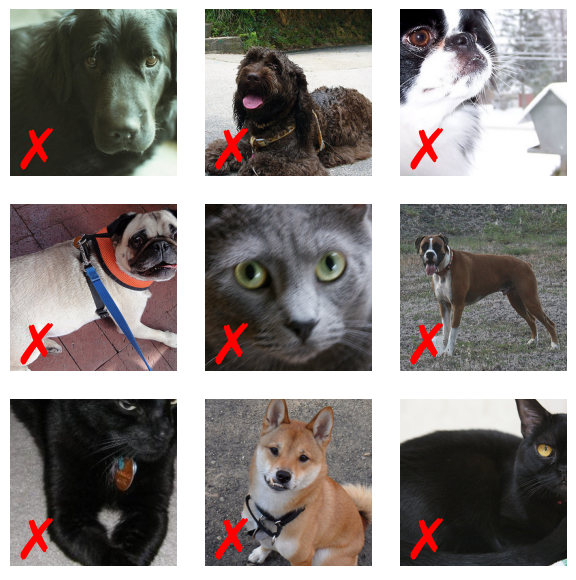

In [24]:
plot_imgs(imgs, fake_labels, labels, figsize=(6, 6))

Before implementing a vision transformer, we need to represent images in a format the model can understand. This requires creating "patches" – dividing the image into many smaller, equal-sized chunks. By treating the image as a sequence of patches (read from left to right, like a book), the transformer can then imbibe the image data!

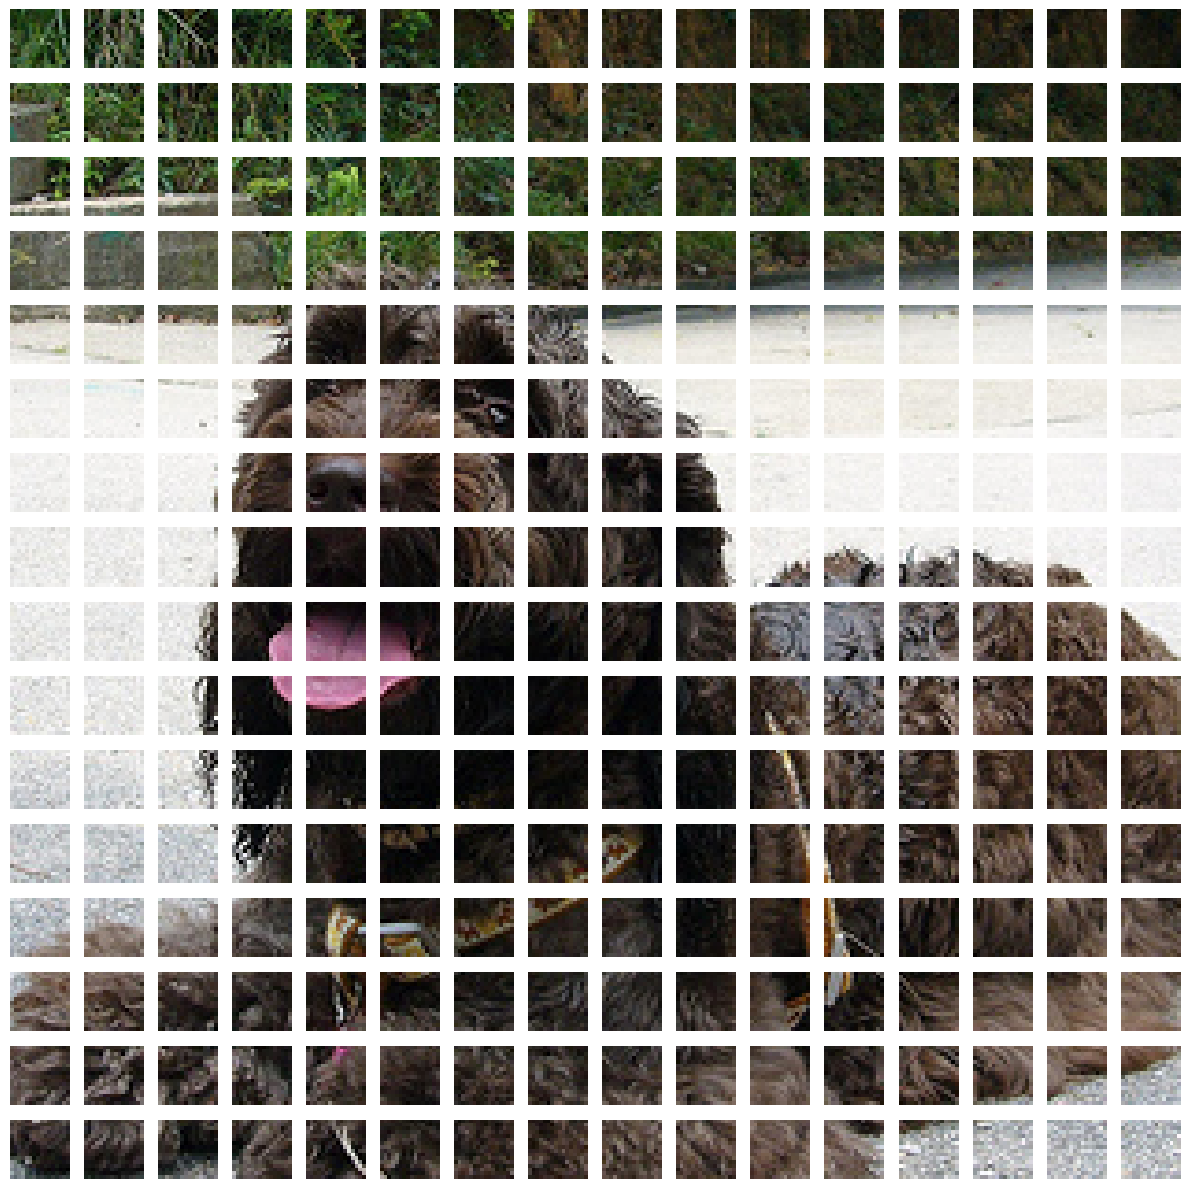

In [47]:
def extract_patches(imgs):
    unbatched = False 
    if imgs.ndim == 3:
        unbatched = True
        imgs = imgs.unsqueeze(0)  # add batch dimension if it's not there
        
    B, C, H, W = imgs.size()

    patches = imgs.unfold(2, PATCH_SIZE, PATCH_SIZE)  # unfold along height
    patches = patches.unfold(3, PATCH_SIZE, PATCH_SIZE)  # unfold along width
    patches = patches.contiguous().view(B, C, -1, PATCH_SIZE, PATCH_SIZE)  # gather the different unfolds
    patches = patches.permute(0, 2, 1, 3, 4).contiguous()  # ensure the dimensions are in the right order before flattening (otherwise they might get jumbled)
    patches = patches.view(B, -1, C * PATCH_SIZE * PATCH_SIZE)  # flatten
    
    return patches.squeeze() if unbatched else patches

plot_imgs(list(extract_patches(imgs[1]).reshape(-1, 3, PATCH_SIZE, PATCH_SIZE)))

So this is effectively what the transformer will see